In [1]:
import pandas as pd
df = pd.read_csv('old_cleaned.csv')
df.head(1)

,CarName,fueltype,price,accident,milage,model_year,ext_col,int_col,HP,motor_size,cylinders
0,Ford,gasoline,10300.0,yes,51000.0,2013.0,Black,Black,300.0,3.7,6.0


In [ ]:
# check nulls and duplicates, value counts for categorical and distrubution for numarical columns

In [2]:
df.isnull().sum()

CarName       0
fueltype      0
price         0
accident      0
milage        0
model_year    0
ext_col       0
int_col       0
HP            0
motor_size    0
cylinders     0
dtype: int64

In [3]:
df.duplicated().sum()

0

In [4]:
df.columns

Index(['CarName', 'fueltype', 'price', 'accident', 'milage', 'model_year',
       'ext_col', 'int_col', 'HP', 'motor_size', 'cylinders'],
      dtype='object')

In [5]:
cat_columns = ['CarName', 'fueltype', 'accident',
       'ext_col', 'int_col']

num_columns = ['price',  'milage', 'model_year','HP', 'motor_size', 'cylinders']

In [9]:
df.shape

(3036, 11)

In [7]:
for i in cat_columns:
    print(len(df[i].value_counts()))
    print('\n')
    print(df[i].value_counts())
    print('-'*50)

51


CarName
BMW              320
Ford             299
Mercedes-Benz    259
Chevrolet        232
Porsche          158
Toyota           156
Audi             155
Lexus            134
Land             102
Jeep              97
Nissan            88
Cadillac          86
Dodge             72
GMC               72
Hyundai           57
Subaru            56
INFINITI          55
RAM               53
Volkswagen        48
Honda             47
Lincoln           44
Acura             41
Kia               40
Jaguar            39
Mazda             35
Volvo             32
MINI              31
Maserati          26
Bentley           22
Chrysler          22
Mitsubishi        19
Buick             17
Genesis           16
Hummer            16
Pontiac           15
Lamborghini       13
Alfa              12
Ferrari            8
Aston              7
Scion              6
Rolls-Royce        5
Saturn             5
FIAT               4
Lotus              4
McLaren            3
Saab               2
Mercury            2


In [ ]:
# the distrubution of the data very good



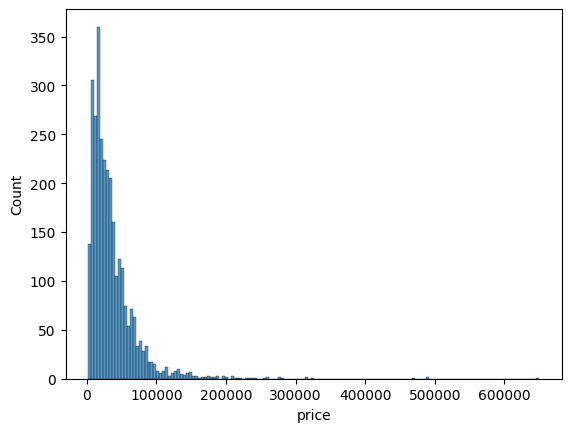

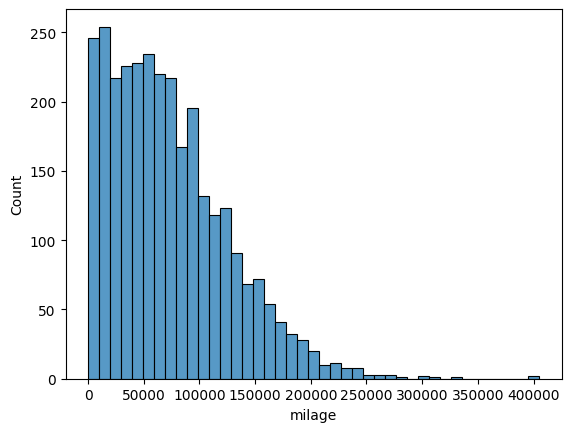

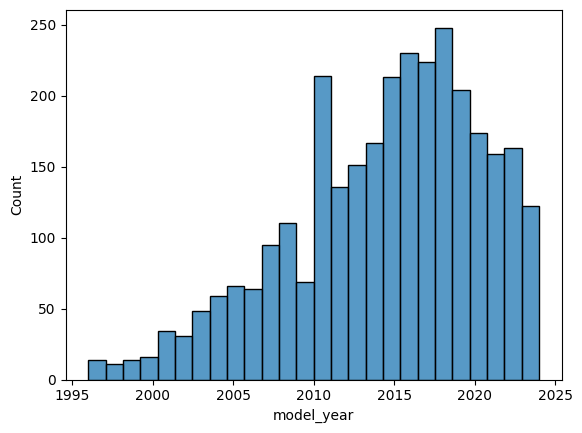

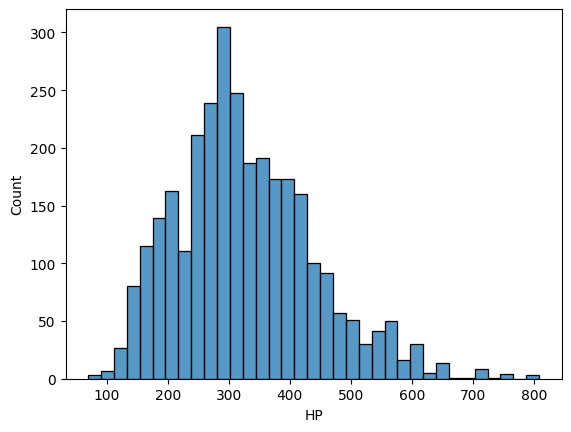

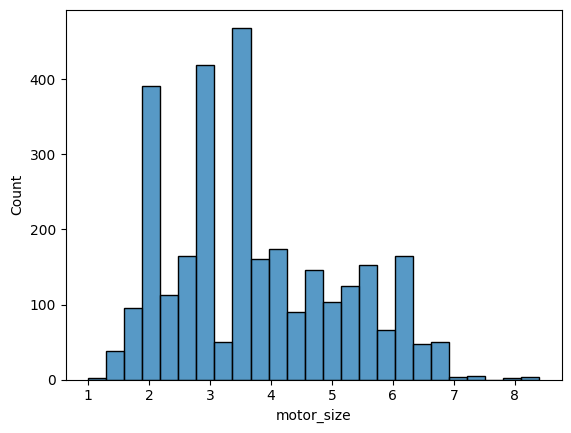

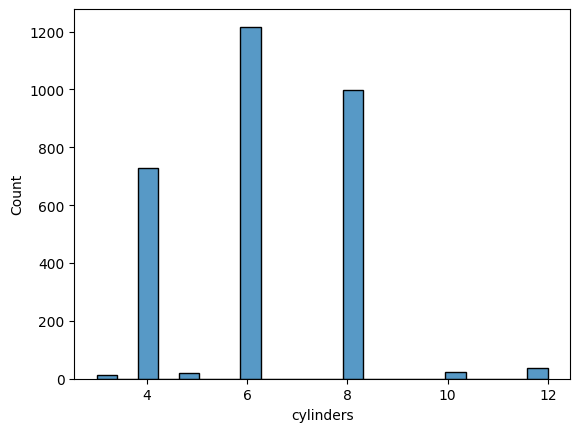

In [10]:
# check numaric dist
import matplotlib.pyplot as plt
import seaborn as sns
for i in num_columns:
    sns.histplot(data=df, x=i)
    plt.show()


In [ ]:
# apply standard scaler on them

- apply standard scaler on the numaric (except the price cause its the target)


- for this features
'CarName', 'ext_col', 'int_col' -> apply binary encoding
'fueltype','accident', -> onehot encoding with drop

- then test those models
LR, SVM linear, SVM polynomial, DT, RF, XGBoost, CatBoost, LightGBM
- then print RMSE and R2

In [ ]:
!pip install xgboost catboost lightgbm category_encoders


In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from category_encoders import BinaryEncoder
import numpy as np

# Define the evaluate_model function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

# Specify your columns
cat_columns = ['CarName', 'fueltype', 'accident', 'ext_col', 'int_col']
num_columns = ['milage', 'model_year', 'HP', 'motor_size', 'cylinders']
target = 'price'

# Split the data
X = df[cat_columns + num_columns]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessors
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

binary_encoder = Pipeline(steps=[
    ('binary', BinaryEncoder())
])

onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('bin_carname', binary_encoder, ['CarName']),
        ('bin_extcol', binary_encoder, ['ext_col']),
        ('bin_intcol', binary_encoder, ['int_col']),
        ('onehot', onehot_transformer, ['fueltype', 'accident'])
    ])

# Define the models
models = {
    'LinearRegression': LinearRegression(),
    'SVM_Linear': SVR(kernel='linear'),
    'SVM_Polynomial': SVR(kernel='poly'),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0),
    'LightGBM': LGBMRegressor()
}

# Custom scorer for RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Train and evaluate models with cross-validation
results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    cv_rmse = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=rmse_scorer)
    cv_r2 = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    pipeline.fit(X_train, y_train)
    rmse, r2 = evaluate_model(pipeline, X_test, y_test)
    results[name] = {'CV_RMSE': np.mean(cv_rmse), 'CV_R2': np.mean(cv_r2), 'Test_RMSE': rmse, 'Test_R2': r2}

# Print the results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"CV RMSE: {metrics['CV_RMSE']}")
    print(f"CV R2: {metrics['CV_R2']}")
    print(f"Test RMSE: {metrics['Test_RMSE']}")
    print(f"Test R2: {metrics['Test_R2']}")
    print('-'*30)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 1942, number of used features: 22
[LightGBM] [Info] Start training from score 36021.780639
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 1942, number of used features: 22
[LightGBM] [Info] Start training from score 36643.896498
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [ ]:
# the best one is the Catboost -> Tune it


In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from catboost import CatBoostRegressor
from category_encoders import BinaryEncoder
import numpy as np
import joblib

# Define the evaluate_model function
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    return rmse, r2

# Specify your columns
cat_columns = ['CarName', 'fueltype', 'accident', 'ext_col', 'int_col']
num_columns = ['milage', 'model_year', 'HP', 'motor_size', 'cylinders']
target = 'price'

# Split the data
X = df[cat_columns + num_columns]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessors
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

binary_encoder = Pipeline(steps=[
    ('binary', BinaryEncoder())
])

onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('bin_carname', binary_encoder, ['CarName']),
        ('bin_extcol', binary_encoder, ['ext_col']),
        ('bin_intcol', binary_encoder, ['int_col']),
        ('onehot', onehot_transformer, ['fueltype', 'accident'])
    ])

# Define the model
catboost_model = CatBoostRegressor(verbose=0)

# Define the parameter grid
param_grid = {
    'model__iterations': [100, 200, 300],
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.05, 0.1]
}

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', catboost_model)])

# Define the custom RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=rmse_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_rmse, test_r2 = evaluate_model(best_model, X_test, y_test)
print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}")

# Refit the best model on the entire dataset
best_model.fit(X, y)
final_rmse, final_r2 = evaluate_model(best_model, X, y)
print(f"Final RMSE on the whole dataset: {final_rmse}")
print(f"Final R2 on the whole dataset: {final_r2}")

# Save the pipeline
joblib.dump(best_model, 'best_catboost_pipeline.pkl')

# Example function to use the saved pipeline
def predict_price(input_data):
    model = joblib.load('best_catboost_pipeline.pkl')
    return model.predict(input_data)

# Example usage
# Load the model and make predictions
example_data = pd.DataFrame({
    'CarName': ['Toyota'],
    'fueltype': ['gasoline'],
    'accident': ['no'],
    'ext_col': ['Black'],
    'int_col': ['Black'],
    'milage': [15000],
    'model_year': [2020],
    'HP': [150],
    'motor_size': [2.0],
    'cylinders': [4]
})
predicted_price = predict_price(example_data)
print(f"Predicted price: {predicted_price}")


Best parameters found:  {'model__depth': 4, 'model__iterations': 100, 'model__learning_rate': 0.01}
Test RMSE: 35671.41258606568
Test R2: 0.4357952528612231
Final RMSE on the whole dataset: 25492.183477188297
Final R2 on the whole dataset: 0.5552771324327922
Predicted price: [42445.16951938]


In [ ]:
# its become so ban when test on all data -> change to RF

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from category_encoders import BinaryEncoder
import numpy as np
import joblib
import pandas as pd

# Define the evaluate_model function
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    return rmse, r2

# Specify your columns
cat_columns = ['CarName', 'fueltype', 'accident', 'ext_col', 'int_col']
num_columns = ['milage', 'model_year', 'HP', 'motor_size', 'cylinders']
target = 'price'


# Split the data
X = df[cat_columns + num_columns]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessors
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

binary_encoder = Pipeline(steps=[
    ('binary', BinaryEncoder())
])

onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('bin_carname', binary_encoder, ['CarName']),
        ('bin_extcol', binary_encoder, ['ext_col']),
        ('bin_intcol', binary_encoder, ['int_col']),
        ('onehot', onehot_transformer, ['fueltype', 'accident'])
    ])

# Define the model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [10, 20]
}

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', rf_model)])

# Define the custom RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=rmse_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_rmse, test_r2 = evaluate_model(best_model, X_test, y_test)
print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}")

# Refit the best model on the entire dataset
best_model.fit(X, y)
final_rmse, final_r2 = evaluate_model(best_model, X, y)
print(f"Final RMSE on the whole dataset: {final_rmse}")
print(f"Final R2 on the whole dataset: {final_r2}")

# Save the pipeline
joblib.dump(best_model, 'oldcars-pipe.pkl')

# Example function to use the saved pipeline
def predict_price(input_data):
    model = joblib.load('oldcars-pipe.pkl')
    return model.predict(input_data)


Best parameters found:  {'model__max_depth': 20, 'model__n_estimators': 50}
Test RMSE: 20995.65959126803
Test R2: 0.8045412279134523
Final RMSE on the whole dataset: 5757.606694727853
Final R2 on the whole dataset: 0.977313924166728


In [19]:
example_data = pd.DataFrame({
    'CarName': ['Toyota'],
    'fueltype': ['gasoline'],
    'accident': ['no'],
    'ext_col': ['Black'],
    'int_col': ['Black'],
    'milage': [15000],
    'model_year': [2020],
    'HP': [150],
    'motor_size': [2.0],
    'cylinders': [4]
})
predicted_price = predict_price(example_data)
print(f"Predicted price: {predicted_price}")

Predicted price: [24889.66]
